In [1]:
library("DESeq2")
library("ggplot2")
library("ggrepel")
library("ggcorrplot")
library("dplyr")
library(stringr)
library(purrr)
library("tibble")
library(dplyr)
library(tidyr)
library(ComplexHeatmap)
library("pals")
library(ggpubr)
library(tximport)
library("ggExtra")
source('./plot_data.R')
theme_set(
    theme_classic(base_size = 12)
)

Warning message:
“package ‘DESeq2’ was built under R version 4.2.3”
Loading required package: S4Vectors

Warning message:
“package ‘S4Vectors’ was built under R version 4.2.3”
Loading required package: stats4

Loading required package: BiocGenerics

Warning message:
“package ‘BiocGenerics’ was built under R version 4.2.1”

Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, aperm, append, as.data.frame, basename, cbind,
    colnames, dirname, do.call, duplicated, eval, evalq, Filter, Find,
    get, grep, grepl, intersect, is.unsorted, lapply, Map, mapply,
    match, mget, order, paste, pmax, pmax.int, pmin, pmin.int,
    Position, rank, rbind, Reduce, rownames, sapply, setdiff, sort,
    table, tapply, union, unique, unsplit, which.max, which.min



Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    exp

ERROR: Error in library(ggpubr): there is no package called ‘ggpubr’


## sacCer3 aresv13 gene annotation

In [77]:
iso_tb<- read.table('../data/ref/sacCer3_ares_v13_sorted.bed')
colnames(iso_tb) <- c('chrom', 'start', 'end', 'iso_id', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts')

iso_tb <- iso_tb %>%
  mutate(
    isolen = map_dbl(
      str_split(blockSizes, ","),
      ~ sum(as.numeric(head(., -1)))  # drop last empty element
    ),
    gene_id = str_split_i(iso_id, "_", 1)
  ) %>%
  arrange(gene_id, desc(isolen))

rownames(iso_tb) = iso_tb$iso_id
dim(iso_tb)
length(unique(iso_tb$gene_id))
# total number of annotated isoforms: 6980
# total number of annotated genes: 6685

[1] 6980   14

[1] 6685

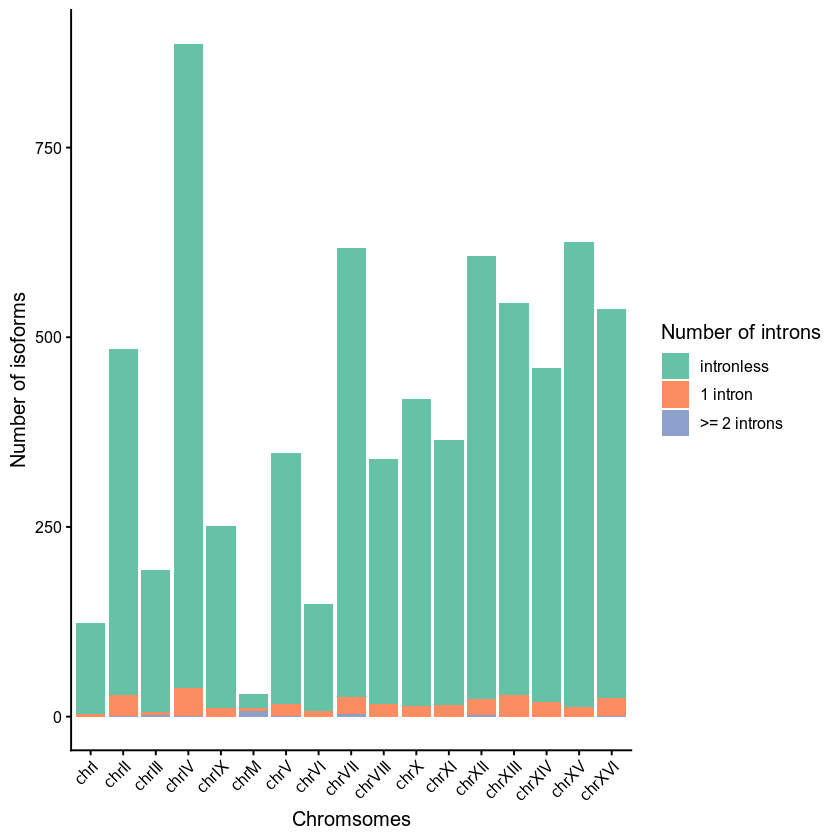

In [224]:
df <- iso_tb %>%
  count(chrom, blockCount) %>%
  mutate(n_intron = case_when(
        blockCount == 1 ~ "intronless",   
        blockCount == 2 ~ "1 intron",
        TRUE ~ ">= 2 introns")) %>%
  mutate(n_intron = factor(n_intron, levels = c("intronless", "1 intron", ">= 2 introns")))

df %>% ggplot(aes(x = chrom, y = n, fill = n_intron))+
    geom_bar(stat = "identity", position = "stack") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1)) +
    labs(x = "Chromsomes", y = "Number of isoforms", fill = "Number of introns") +
    scale_fill_brewer(palette = "Set2")

ggsave('../figures/Supp_aresv13_isoform_stat.pdf', width = 6, height = 3)

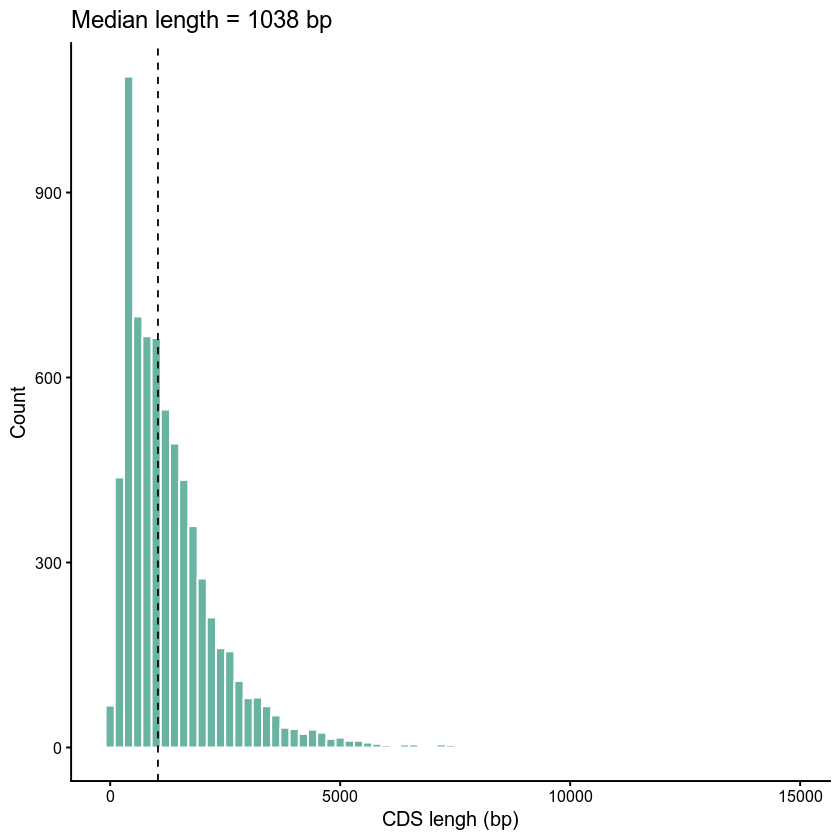

In [63]:
median_len <- median(iso_tb$isolen, na.rm = TRUE)
ggplot(iso_tb, aes(x = isolen)) + 
    geom_histogram(binwidth = 200, fill = "#69b3a2", color = "white") +
    geom_vline(xintercept = median_len, color = "black", linetype = "dashed", linewidth = 0.5) +
    labs(x = 'CDS lengh (bp)', y = "Count", title = paste0("Median length = ", median_len, " bp"))

ggsave('../figures/Supp_aresv13_isoform_length.pdf', width = 4, height = 3)

In [69]:
iso_tb %>% count(blockCount)
intronic = 283 + 14 + 2 + 3
print("intron containing:")
intronic 

blockCount,n
<int>,<int>
1,6590
2,283
3,14
4,2
5,1
6,1
8,1


[1] "intron containing:"


[1] 302

## short genes

In [131]:
txi<- readRDS('../data/1_total_rna_rsem_gene_txi.obj')
table(rowSums(txi$length == 0) != 0)
short_gene <- rownames(txi$length[rowSums(txi$length == 0) != 0, ])
print('total number of short genes:')
length(short_gene)


FALSE  TRUE 
 6479   207 

[1] "total number of short genes:"


[1] 207

## get an idea of number of snRNAs

In [75]:
snrna_genes<- rownames(iso_tb)[rownames(iso_tb) %>% grepl(pattern = "^snR.*")]
print('total number of snRNA:')
length(snrna_genes)
write.table(snrna_genes, '../data/ref/ares_v13_snRNA.tsv', sep = "\t", quote = FALSE, row.names = F, col.names = F)

[1] "total number of snRNA:"


[1] 79

## sub telomeric genes

In [83]:
sub_telo<- read.table("../data/ref/sub_telomericGenes_6kb.bed", header = FALSE, sep = "\t")
colnames(sub_telo)<- c("chr", "start", "end", "gene_id", "score", "strand")
sub_telo_genes<- unique(sub_telo$gene_id)
length(sub_telo_genes)

[1] 98

## Uniquelly mappable genes with minimum read length of 800 bp
**run ./sh/2_remove_unmappable_genes.sh to get mappable_genes.bed**

In [79]:
iso_tb_umap<- read.table('../data/ref/sacCer3_ares_v13_mappable_genes.bed')
colnames(iso_tb_umap) <- c('chrom', 'start', 'end', 'iso_id', 'score', 'strand', 'thickStart', 'thickEnd', 'itemRgb', 'blockCount', 'blockSizes', 'blockStarts')

iso_tb_umap <- iso_tb_umap %>%
  mutate(
    isolen = map_dbl(
      str_split(blockSizes, ","),
      ~ sum(as.numeric(head(., -1)))  # drop last empty element
    ),
    gene_id = str_split_i(iso_id, "_", 1)
  ) %>%
  arrange(gene_id, desc(isolen))

rownames(iso_tb_umap) = iso_tb_umap$iso_id
dim(iso_tb_umap)
length(unique(iso_tb_umap$gene_id))
# total number of annotated isoforms: 6892
# total number of annotated genes: 6597

[1] 6892   14

[1] 6597

## overlapping in tandom genes

In [85]:
gene_nb<- read.table("../data/ref/sacCer3_aresv13_gene_gene_correlation.bed", header = FALSE, sep = "\t")

colnames(gene_nb)<- c("chr", "start", "end", "gene", "strand", "left_gene", "left_strandness", "left_dist", "right_gene", "right_strandness", "right_dist", "child_gene", "mother_gene", "overlap", "promoter_dist")
rownames(gene_nb)<- gene_nb$gene

gene_nb<- gene_nb %>%
            mutate(promoter_strandness = if_else(strand == "+", right_strandness, left_strandness),
                              end_strandness = if_else(strand == "+", left_strandness, right_strandness),
                              is_mother = if_else(mother_gene == gene, "is mother", "no"), 
                              is_child = if_else(child_gene == gene, "is child", "no")) %>% 
            filter(chr != 'chrM')

mother_gene<- gene_nb %>% filter(is_mother == "is mother") %>% rownames()
child_gene<- gene_nb %>% filter(is_child == "is child") %>% rownames()

## filter all above isoforms

In [132]:
isoforms_to_remove<- c(short_gene, snR_genes, sub_telo_genes, mother_gene, child_gene) %>% sort() %>% unique()
length(isoforms_to_remove)

[1] 593

In [157]:
final_iso_tb<- iso_tb_umap %>% 
    filter(chrom != 'chrM') %>% 
    filter(!iso_id %in% isoforms_to_remove) %>% 
    filter(!gene_id %in% isoforms_to_remove)

dim(final_iso_tb)
length(unique(final_iso_tb$gene_id))
# final number of annotated isoforms: 6292
# final number of annotated genes: 6016

[1] 6292   14

[1] 6016

## Classify genes into low-, median-, high-expression group

In [225]:
tpm<- read.table('../data/1_total_rna_rsem_gene_TPM.tsv')

In [226]:
tpm<- tpm[rownames(tpm) %in% final_iso_tb$gene_id, ]

### no expression genes: 258

In [227]:
ave_wt_tpm<- data.frame(ave = rowSums(tpm[, c(1:3)])/3)
no_expression<- ave_wt_tpm %>% filter(ave ==0) %>% mutate(class = "low")
print('no expression')
print(nrow(no_expression))

ave_wt_tpm_no_zero  <- ave_wt_tpm %>% filter(ave != 0) 
ave_wt_tpm_no_zero<- ave_wt_tpm_no_zero %>% arrange(ave) %>% mutate(rank = 1:nrow(ave_wt_tpm_no_zero))

[1] "no expression"
[1] 258


### low, medium, and high genes: 1152, 3453, 1153

In [228]:
lower_0.2_p = round(nrow(ave_wt_tpm_no_zero) * 0.2, 0)
higher_0.2_p = nrow(ave_wt_tpm_no_zero) - lower_0.2_p
f
ave_wt_tpm_no_zero<- ave_wt_tpm_no_zero %>% mutate(class = case_when(rank <= lower_0.2_p ~ 'low', 
                                                                     rank >= higher_0.2_p ~ 'high', 
                                                                     TRUE ~ 'medium')) %>% select(-rank)

ave_wt_tpm_no_zero$class<- factor(ave_wt_tpm_no_zero$class, levels = c('low', 'medium', 'high'))
table(ave_wt_tpm_no_zero$class)


   low medium   high 
  1152   3453   1153 

In [229]:
expr_annot<- rbind(ave_wt_tpm_no_zero, no_expression)
table(expr_annot$class)

expr_annot %>% filter(class == "low") %>% rownames() %>% 
    write.table(file = '../data/2_genes_low_expression.tsv', sep = '\t', quote = FALSE, col.names = FALSE, row.names = FALSE)

expr_annot %>% filter(class == "medium") %>% rownames() %>% 
    write.table(file = '../data/2_genes_medium_expression.tsv', sep = '\t', quote = FALSE, col.names = FALSE, row.names = FALSE)

expr_annot %>% filter(class == "high") %>% rownames() %>% 
    write.table(file = '../data/2_genes_high_expression.tsv', sep = '\t', quote = FALSE, col.names = FALSE, row.names = FALSE)


   low medium   high 
  1410   3453   1153 

In [230]:
final_iso_tb$class =  expr_annot[match(final_iso_tb$gene_id, rownames(expr_annot)), 'class']
table(final_iso_tb$class)


   low medium   high 
  1476   3538   1278 

In [231]:
head(final_iso_tb)

,chrom,start,end,iso_id,score,strand,thickStart,thickEnd,itemRgb,blockCount,blockSizes,blockStarts,isolen,gene_id,class
,<chr>,<int>,<int>,<chr>,<int>,<chr>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>,<chr>,<fct>
AAC1,chrXIII,387314,388244,AAC1,1000,-,387314,388244,0,1,"930,","0,",930,AAC1,low
AAC3,chrII,415982,416906,AAC3,1000,+,415982,416906,0,1,"924,","0,",924,AAC3,medium
AAD10,chrX,727404,728271,AAD10,1000,+,727404,728271,0,1,"867,","0,",867,AAD10,low
AAD14,chrXIV,16117,17248,AAD14,1000,-,16117,17248,0,1,"1131,","0,",1131,AAD14,low
AAD16,chrVI,14304,14763,AAD16,1000,-,14304,14763,0,1,"459,","0,",459,AAD16,medium
AAD4,chrIV,17576,18566,AAD4,1000,-,17576,18566,0,1,"990,","0,",990,AAD4,low


In [232]:
write.table(final_iso_tb, '../data/2_final_iso_tb.tsv', sep = "\t", quote = F, col.names = T, row.names = T)